# **INTRODUCTION**

This project focuses on spam classification using machine learning techniques such as K-nearest neighbors(KNN), Decision Tree, Logistic Regression; Naive Bayes, SVM.

The goal is to develop a model that can accurately classify emails as either spam or ham (non-spam).

# **IMPORT LIBRERIES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re, nltk
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation
from operator import index
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **LAOD DATASETS**

In [2]:
easy_ham_path = 'Data/easy_ham/easy_ham/'
hard_ham_path = 'Data/hard_ham/hard_ham/'
spam_2_path = 'Data/spam_2/spam_2/'

In the DataFrame named **df**, you will find labeled columns as follows:

1.   'email' : for email content
2.   'label' : takes **1** for **Ham email** and **0** for **Spam email**


In [3]:
df = pd.DataFrame(columns=['email','label'])

The **load_data** function load email data from the given path and assign a label to each email.

The function takes two parameters:

*   **path** (the path to the email data)
*   **label** (the label to assign to the emails).  

It initializes an empty list called **data** to store the email data and labels.  
It uses the **os.listdir()** function to retrieve a list of files in the specified path, then iterates over each file in the directory and opens it using the **open()** function, Then read it and store it in the **dt** variable.  
The email data and label are appended to the **data** list as a list **[dt, label]** and converted to a NumPy array using **np.array(data)**.  
Finally, the NumPy array is converted to a pandas DataFrame with columns named **'email'** and **'label'**, and returned.

In [4]:
def load_data (path,label):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path + file, 'r', encoding='ISO-8859-1')
        dt = f.read()
        data.append([dt, label])
    nd_array = np.array(data)
    return pd.DataFrame(nd_array,columns=['email','label'])

We apply The **load_data** function to each piece of data with given labels

In [5]:
easy_ham = load_data(easy_ham_path, 1)
hard_ham = load_data(hard_ham_path, 1)
spam_2 = load_data(spam_2_path, 0)

Here we concatenate all the three DataFrames into the dataframe **df** we created earlier.  
**'ignore_index=True'** argument ensures that the resulting DataFrame has a new sequential index, ignoring the original indices of the individual DataFrames.

In [6]:
df = pd.concat([easy_ham, hard_ham, spam_2], ignore_index=True)
df

,email,label
0,From exmh-workers-admin@redhat.com Thu Aug 22...,1
1,From Steve_Burt@cursor-system.com Thu Aug 22 ...,1
2,From timc@2ubh.com Thu Aug 22 13:52:59 2002\n...,1
3,From irregulars-admin@tb.tf Thu Aug 22 14:23:...,1
4,From exmh-users-admin@redhat.com Thu Aug 22 1...,1
...,...,...
4193,From tba@insiq.us Wed Dec 4 11:46:34 2002\nR...,0
4194,Return-Path: <raye@yahoo.lv>\nReceived: from u...,0
4195,From cweqx@dialix.oz.au Tue Aug 6 11:03:54 2...,0
4196,From ilug-admin@linux.ie Wed Dec 4 11:52:36 ...,0


When reading data from file,the DataFrame's values type by default is String, so we need to convert the labels into integers, and for tha we use **astype(int)** method.

In [7]:
df['label'] = df['label'].astype(int)

# **PREPROCESSING DATA**

Preprocessing data is an important step, as raw data can be inconsistent or incomplete in its formatting. For our data we perform some changes in order to be able to work with it :

* **Lowercasing the email:** converting all characters in the 'email' column to lowercase using the .str.lower() method.  
* **Removing HTML tags:** applying a regular expression (re.sub) to remove any HTML tags from the 'email' column by replacing them with a space.  
* **Normalizing URLs:** replacing any URLs starting with 'http' or 'https' with the string 'httpaddr' using a regular expression.  
* **Normalizing email addresses:** replacing any email addresses with the string 'emailaddr' using a regular expression.  
* **Normalizing numbers:** replacing any numeric digits with the string 'nombre' using a regular expression.  
* **Normalizing dollar sign:** replacing the dollar symbol ('$') with the string 'dollar'.  
* **Word stemming:** applying word stemming to each email by splitting the text into individual words, applying stemming using PorterStemmer, and joining the stemmed words back together.  
* **Removing non-words and extra spaces:** removing non-word characters (non-alphanumeric) and extra spaces using regular expressions.  
* **Removing punctuation:** removing punctuation marks from the email using the translate method and str.maketrans.  
* **Removing stopwords:** removing common English stopwords from the email by splitting the text into words and joining back only the words that are not in the set of stopwords.

In [8]:
def processing(data):
    # Lowercase the email
    data['email'] = data['email'].str.lower()

    # Remove HTML tags
    data['email'] = data['email'].apply(lambda x: re.sub('<.*?>', ' ', x))

    # Normalize URL => Look for strings starting with http or https
    data['email'] = data['email'].apply(lambda x: re.sub('https?://[w]{3}\.[a-zA-Z0-9]+\.[a-z]{2,4}', 'httpaddr', x))

    # Normalize email
    data['email'] = data['email'].apply(lambda x: re.sub('[^\s]+@[^\s]+', 'emailaddr', x))

    # Normalize numbers
    data['email'] = data['email'].apply(lambda x: re.sub('[0-9]+', 'nombre', x))

    # Normalize $
    data['email'] = data['email'].apply(lambda x: re.sub('[$]', 'dollar', x))

    # Word stemming
    porter = PorterStemmer()
    data['email'] = data['email'].apply(lambda x: x.split())
    data['email'] = data['email'].apply(lambda x: [porter.stem(word.strip()) for word in x])
    data['email'] = data['email'].apply(lambda x: ' '.join(x))

    # Remove non-words and extra spaces
    data['email'] = data['email'].apply(lambda x: re.sub(r'\W+', ' ', x).strip())
    data['email'] = data['email'].apply(lambda x: re.sub(r'\s+', ' ', x))

    # Remove punctuation
    data['email'] = data['email'].apply(lambda x: x.translate(str.maketrans('', '', punctuation)))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    data['email'] = data['email'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

    return data


In [9]:
non_processed_email = df.iloc[0]['email']
non_processed_email

'From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002\nReturn-Path: <exmh-workers-admin@example.com>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)\nReceived: from listman.example.com (listman.example.com [66.187.233.211]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for\n    <zzzz-exmh@example.com>; Thu, 22 Aug 2002 12:34:53 +0100\nReceived: from listman.example.com (localhost.localdomain [127.0.0.1]) by\n    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002\n    07:35:02 -0400 (EDT)\nDelivered-To: exmh-workers@listman.example.com\nReceived: from int-mx1.corp.example.com (int-mx1.corp.example.com\n    [

applying the processing funtion on our DataFrame

In [10]:
processing(df)

,email,label
0,emailaddr thu aug nombr nombre nombre nombr no...,1
1,emailaddr thu aug nombr nombre nombre nombr no...,1
2,emailaddr thu aug nombr nombre nombre nombr no...,1
3,emailaddr thu aug nombr nombre nombre nombr no...,1
4,emailaddr thu aug nombr nombre nombre nombr no...,1
...,...,...
4193,emailaddr wed dec nombr nombre nombre nombr no...,0
4194,return path received usernombre pro ns net use...,0
4195,emailaddr tue aug nombr nombre nombre nombr no...,0
4196,emailaddr wed dec nombr nombre nombre nombr no...,0


In [11]:
processed_email = df.iloc[0]['email']
processed_email

'emailaddr thu aug nombr nombre nombre nombr nombr return path delivered emailaddr received localhost localhost nombre nombre nombre nombre phobos labs netnoteinc com postfix esmtp id dnombreenombrecnombr thu nombr aug nombr nombre nombre nombr nombr edt received phobo nombre nombre nombre nombre localhost imap fetchmail nombre nombre nombre emailaddr single drop thu nombr aug nombr nombre nombre nombr nombr ist received listman example com listman example com nombre nombre nombre nombre dogma slashnull org nombre nombre nombre nombre nombre nombre esmtp id gnombrembyrznombr thu nombr aug nombr nombre nombre nombr nombr received listman example com localhost localdomain nombre nombre nombre nombre listman redhat com postfix esmtp id nombre thu nombr aug nombr nombre nombre nombr nombr edt delivered emailaddr received int mxnombre corp example com int mxnombre corp example com nombre nombre nombre nombre listman redhat com postfix esmtp id nombrecfnombrednombr thu nombr aug nombr nombre

In [12]:
spam_df = df[df['label'] == 0]
spam_df

,email,label
2801,emailaddr tue aug nombr nombre nombre nombr no...,0
2802,emailaddr mon jun nombr nombre nombre nombr no...,0
2803,emailaddr mon jun nombr nombre nombre nombr no...,0
2804,emailaddr mon jun nombr nombre nombre nombr no...,0
2805,emailaddr tue aug nombr nombre nombre nombr no...,0
...,...,...
4193,emailaddr wed dec nombr nombre nombre nombr no...,0
4194,return path received usernombre pro ns net use...,0
4195,emailaddr tue aug nombr nombre nombre nombr no...,0
4196,emailaddr wed dec nombr nombre nombre nombr no...,0


# **VOCABULARY**

The purpose of creating this vocabulary is to analyze the word frequencies in the email data. It can be used for tasks such as feature selection.

Our function create_vocabulary(data) take the preprocessed DataFrame as a paramater and performs the following steps:
* Initialize an empty dictionary, word_freq, to store the word frequencies.  
* Iterate over each email in the DataFrame, accessing the 'email' column.  
* Split the email text into individual words by using the split() function. This creates a list of words.  
* For each word in the list, check if it already exists in the word_freq dictionary.  
 * If the word is already in the dictionary, increment its frequency count by
 * If the word is not in the dictionary, add it as a new key and set its frequency count to 1.  
* Repeat this process for all the emails in the DataFrame.
* Finally, the function returns the word_freq dictionary, which contains the vocabulary of words and their respective frequencies.  

In [13]:
def create_vocabulary(data):
    # Create a list to store the word frequencies
    word_freq = {}

    # Iterate over each email in the DataFrame
    for row in data['email']:
        # Check if the email is a spam (label = 1)
        # if row['label'] == 0:
            # Split the email into individual words
            words = row.split()

            # Count the frequency of each word
            for word in words:
                if word in word_freq:
                    word_freq[word] += 1
                else:
                    word_freq[word] = 1


    return word_freq

We need to create the vocabulary only from spam emails by calling the function create_vocabulary(spam_df) and store the frequency dictionary in a text file named "vocab.txt".

In [14]:
freq_dict = create_vocabulary(spam_df)
with open('vocab.txt', 'w') as file:
  file.write('\n'.join(freq_dict))

freq_dict

{'emailaddr': 11300,
 'tue': 1532,
 'aug': 1288,
 'nombr': 56381,
 'nombre': 102038,
 'return': 1437,
 'path': 1222,
 'delivered': 793,
 'received': 6014,
 'localhost': 1925,
 'phobos': 507,
 'labs': 1552,
 'netnoteinc': 1710,
 'com': 7387,
 'postfix': 966,
 'esmtp': 3141,
 'id': 6548,
 'nombreenombrefnombredd': 1,
 'edt': 770,
 'phobo': 166,
 'imap': 389,
 'fetchmail': 543,
 'single': 554,
 'drop': 605,
 'ist': 617,
 'lugh': 93,
 'tuatha': 75,
 'org': 1441,
 'dogma': 1190,
 'slashnull': 1189,
 'gnombrelqwvnombr': 1,
 'fri': 911,
 'waanombre': 3,
 'bettyjagessar': 3,
 'wnombre': 15,
 'znombre': 17,
 'nyc': 21,
 'ny': 22,
 'dsl': 86,
 'cnc': 12,
 'net': 4007,
 'waanombr': 16,
 'x': 3801,
 'authentication': 93,
 'warning': 97,
 'host': 167,
 'claim': 233,
 'smtpdnombre': 53,
 'eval': 13,
 'anombreanombrefcnombrefnombre': 1,
 'message': 1623,
 'date': 2071,
 'start': 468,
 'mime': 1420,
 'version': 1920,
 'content': 3268,
 'type': 2450,
 'text': 2309,
 'plain': 599,
 'charset': 1377,
 'us

For further uses we ordered the frequency dictionary in descending order based on values

In [15]:
#order vocabulary dict
sorted_dict = dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
sorted_dict

{'nombre': 102038,
 'nombr': 56381,
 'nombred': 19901,
 'emailaddr': 11300,
 'nbsp': 10278,
 'com': 7387,
 'id': 6548,
 'received': 6014,
 'font': 5635,
 'size': 4937,
 'thi': 4832,
 'jul': 4383,
 'net': 4007,
 'x': 3801,
 'color': 3786,
 'mail': 3457,
 'content': 3268,
 'face': 3245,
 'anombre': 3153,
 'esmtp': 3141,
 'bnombre': 3004,
 'http': 2970,
 'nombree': 2961,
 'email': 2697,
 'dnombre': 2563,
 'width': 2455,
 'type': 2450,
 'may': 2420,
 'cnombre': 2392,
 'list': 2384,
 'dollarnombre': 2350,
 'text': 2309,
 'httpaddr': 2297,
 'nombrec': 2252,
 'free': 2145,
 'arial': 2076,
 'date': 2071,
 'nombrednombre': 2059,
 'mon': 1980,
 'localhost': 1925,
 'version': 1920,
 'subject': 1898,
 'border': 1751,
 'click': 1732,
 'netnoteinc': 1710,
 'height': 1702,
 'us': 1684,
 'cc': 1682,
 'name': 1632,
 'e': 1630,
 'message': 1623,
 'labs': 1552,
 'tue': 1532,
 'get': 1525,
 'smtp': 1511,
 'html': 1505,
 'nombrednombr': 1464,
 'jun': 1452,
 'org': 1441,
 'fnombre': 1441,
 'return': 1437,
 

In this step we get the final list of words to work with.

* The variable K is set to a value of 10000. This value represents the desired number of top frequent words to select from the vocabulary.  
* Slices the sorted dictionary to include only the first K items, effectively selecting the top K most frequent words along with their corresponding frequencies.

In [16]:
K= 10000
filtered_dict = dict(list(sorted_dict.items())[:K])
filtered_dict

{'nombre': 102038,
 'nombr': 56381,
 'nombred': 19901,
 'emailaddr': 11300,
 'nbsp': 10278,
 'com': 7387,
 'id': 6548,
 'received': 6014,
 'font': 5635,
 'size': 4937,
 'thi': 4832,
 'jul': 4383,
 'net': 4007,
 'x': 3801,
 'color': 3786,
 'mail': 3457,
 'content': 3268,
 'face': 3245,
 'anombre': 3153,
 'esmtp': 3141,
 'bnombre': 3004,
 'http': 2970,
 'nombree': 2961,
 'email': 2697,
 'dnombre': 2563,
 'width': 2455,
 'type': 2450,
 'may': 2420,
 'cnombre': 2392,
 'list': 2384,
 'dollarnombre': 2350,
 'text': 2309,
 'httpaddr': 2297,
 'nombrec': 2252,
 'free': 2145,
 'arial': 2076,
 'date': 2071,
 'nombrednombre': 2059,
 'mon': 1980,
 'localhost': 1925,
 'version': 1920,
 'subject': 1898,
 'border': 1751,
 'click': 1732,
 'netnoteinc': 1710,
 'height': 1702,
 'us': 1684,
 'cc': 1682,
 'name': 1632,
 'e': 1630,
 'message': 1623,
 'labs': 1552,
 'tue': 1532,
 'get': 1525,
 'smtp': 1511,
 'html': 1505,
 'nombrednombr': 1464,
 'jun': 1452,
 'org': 1441,
 'fnombre': 1441,
 'return': 1437,
 

We created a mapping between the words in an email and their corresponding indices in the vocabulary list.

* We initialized an empty list called indices to store the indices of the words in the email that are present in the vocabulary list.  
* We split the email text into individual words using the split() function, storing them in the words list.  
* We iterated over each word in the words list.  
* For each word, we checked if it exists in the vocabList (the vocabulary list).  
* If the word is found in the vocabList, we retrieved its index using the index() function and assigns it to the variable word_index.  
* The word_index is then appended to the indices list.  
* After iterating over all the words in the email, the function returns the indices list, which contains the positions of the words in the email that match words in the vocabulary list.  

In [17]:
def map_indices(email, vocabList):
    indices = []
    words = email.split()

    for word in words:
        if word in vocabList:
            word_index = vocabList.index(word)
            indices.append(word_index)

    return indices

Applying the "map_indices" function to the DataFrame and add new column for indices.

In [18]:
vocabList = list(filtered_dict.keys())
df['indice'] = df['email'].apply(lambda x: map_indices(x, vocabList))

df

,email,label,indice
0,emailaddr thu aug nombr nombre nombre nombr no...,1,"[3, 65, 74, 1, 0, 0, 1, 1, 60, 81, 118, 3, 7, ..."
1,emailaddr thu aug nombr nombre nombre nombr no...,1,"[3, 65, 74, 1, 0, 0, 1, 1, 60, 81, 118, 3, 7, ..."
2,emailaddr thu aug nombr nombre nombre nombr no...,1,"[3, 65, 74, 1, 0, 0, 1, 1, 60, 81, 118, 3, 7, ..."
3,emailaddr thu aug nombr nombre nombre nombr no...,1,"[3, 65, 74, 1, 0, 0, 1, 1, 60, 81, 118, 3, 7, ..."
4,emailaddr thu aug nombr nombre nombre nombr no...,1,"[3, 65, 74, 1, 0, 0, 1, 1, 60, 81, 118, 3, 7, ..."
...,...,...,...
4193,emailaddr wed dec nombr nombre nombre nombr no...,0,"[3, 62, 720, 1, 0, 0, 1, 1, 60, 81, 118, 3, 7,..."
4194,return path received usernombre pro ns net use...,0,"[60, 81, 7, 1159, 109, 115, 12, 1159, 109, 115..."
4195,emailaddr tue aug nombr nombre nombre nombr no...,0,"[3, 52, 74, 1, 0, 0, 1, 1, 60, 81, 118, 3, 7, ..."
4196,emailaddr wed dec nombr nombre nombre nombr no...,0,"[3, 62, 720, 1, 0, 0, 1, 1, 60, 81, 118, 3, 7,..."


# **DATA EXTRACTION**

Data extraction is commonly used in text classification tasks to convert text data into a numerical representation suitable for machine learning algorithms.

For this we perfom the following steps:

* Initialize an empty list called features to store the feature vectors for each email.  
* Iterates over each email in the data DataFrame.  
* For each email, Initialize an empty list called feature_vector to store the binary values (1 or 0) indicating the presence or absence of words from the vocabulary list.
* Then iterate over each word in the vocabList.  
* For each word, Check if the word is present in the email by using the in operator.  
* If the word is present in the email, append a value of 1 to the feature_vector list. Otherwise, append a value of 0.  
* After iterating over all the words in the vocabList, append the feature_vector to the features list.  
* Finally, create a new DataFrame features using the pd.DataFrame() function, passing the features list as data and vocabList as the column names.
* The resulting DataFrame features represents the presence or absence of words from the vocabulary list in each email, with each row corresponding to an email and each column corresponding to a word from the vocabulary list.


In [19]:
def features_extraction(data, vocabList):
    features = []

    for email in data['email']:
        feature_vector = []
        for word in vocabList:
            feature_vector.append(1 if word in email else 0)
        features.append(feature_vector)

    return pd.DataFrame(features, columns=vocabList)

In [20]:
features = features_extraction(df, vocabList)
features

,nombre,nombr,nombred,emailaddr,nbsp,com,id,received,font,size,...,een,madison,whichev,infomatika,cellpaddi,headernombre,decor,dissatisfi,viral,ass
0,1,1,1,1,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2,1,1,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,1,1,0,1,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,1
4194,1,1,0,1,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4195,1,1,0,1,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4196,1,1,1,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1


# **DATA SPLIT**

First we binarized the labels (Y) which is a common preprocessing step in certain machine learning tasks, particularly when dealing with multi-class classification problems.

The binarization process converts the categorical labels into a binary format, which can be more suitable for certain algorithms like Logistic Regression.

In [21]:
X = features.values
Y = df['label']

y_bin = label_binarize(Y, classes=np.unique(Y))

We split the data into test and train data to help assess the model's ability to generalize and make predictions on unseen data, providing an estimate of its performance on real-world scenarios.

* The parameter **test_size** specifies the proportion of the dataset that should be allocated to the testing set. In this case, 20% of the data will be used for testing, while the remaining 80% will be used for training.

* The parameter **random_state** sets a random seed, which ensures reproducibility. By setting a specific value (in this case, 42), the random splitting of the data will be the same every time the code is executed, allowing for consistent and comparable results.

In [22]:
X_train, X_test, y_train_bin, y_test_bin = train_test_split(features, y_bin, test_size=0.2, random_state=42)
print("Train set shape:", X_train.shape, y_train_bin.shape)
print("Test set shape:", X_test.shape, y_test_bin.shape)

Train set shape: (3358, 10000) (3358, 1)
Test set shape: (840, 10000) (840, 1)


In [23]:
def compute_metrics(Y_tain, y_pred_train, Y_test, y_pred_test,label):
  if label == 'Train':
    print("Metrics for Train data")
    accuracy = accuracy_score(Y_tain, y_pred_train)
    precision = precision_score(Y_tain, y_pred_train)
    recall = recall_score(Y_tain, y_pred_train)
    f1 = f1_score(Y_tain, y_pred_train)
  else :
    print("Metrics for Test data")
    accuracy = accuracy_score(Y_test, y_pred_test)
    precision = precision_score(Y_test, y_pred_test)
    recall = recall_score(Y_test, y_pred_test)
    f1 = f1_score(Y_test, y_pred_test)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

In [24]:
def plot_confusion_matrix(conf_mat,label):
  fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
  fig.suptitle(label + ' Confusion matrix', c='b')
  sns.heatmap(conf_mat/np.sum(conf_mat), ax=axes[0], annot=True,
            fmt='.2%', cmap='Blues')
  axes[0].set_xlabel('Predicted labels')
  axes[0].set_ylabel('Actual labels')

  sns.heatmap(conf_mat, ax=axes[1], annot=True, cmap='Blues', fmt='')
  axes[1].set_xlabel('Predicted labels')
  axes[1].set_ylabel('Actual labels')
  plt.show()

In [25]:
def plot_roc_curve(classifier, X_train, y_train_bin, X_test, y_test_bin):
    # Get predicted probabilities for the positive class
    y_train_pred_proba = classifier.predict_proba(X_train)[:, 1]
    y_test_pred_proba = classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curves
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train_bin, y_train_pred_proba)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test_bin, y_test_pred_proba)

    # Compute AUC scores
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)

    plt.figure(figsize=(10, 4))

    # Plot ROC curve for train data
    plt.subplot(1, 2, 1)
    plt.plot(train_fpr, train_tpr, label='Train ROC curve (area = %0.2f)' % train_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Train ROC Curve')
    plt.legend(loc="lower right")

    # Plot ROC curve for test data
    plt.subplot(1, 2, 2)
    plt.plot(test_fpr, test_tpr, label='Test ROC curve (area = %0.2f)' % test_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Test ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()




# **KNN**

In [26]:
k_values= np.arange(1, 31, 2)
knn_scores = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train, y_train_bin.ravel(), cv=5, scoring='f1')
    knn_scores.append(scores.mean())

Text(0.5, 1.0, 'KNN scores for different k values')

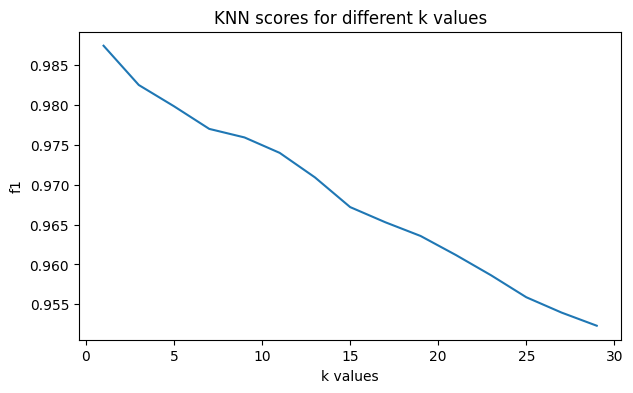

In [27]:
# plot the scoes for each k value
plt.figure(figsize=(7, 4))
plt.plot(k_values, knn_scores)
plt.xlabel('k values')
plt.ylabel('f1')
plt.title('KNN scores for different k values')

In [28]:
# the best k value
k = k_values[np.argmax(knn_scores)]
print('The best k value is : ', k)

The best k value is :  1


In [29]:
KNN_classifier = KNeighborsClassifier(k)
KNN_classifier = KNN_classifier.fit(X_train, y_train_bin.ravel())

y_pred_test = KNN_classifier.predict(X_test)
y_pred_train = KNN_classifier.predict(X_train)

In [30]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Train')

Metrics for Train data
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [31]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Test')

Metrics for Test data
Accuracy: 0.9845238095238096
Precision: 0.9829642248722317
Recall: 0.9948275862068966
F1 Score: 0.9888603256212511


In [32]:
conf_mat_test = confusion_matrix(y_test_bin, y_pred_test)
conf_mat_train = confusion_matrix(y_train_bin, y_pred_train)

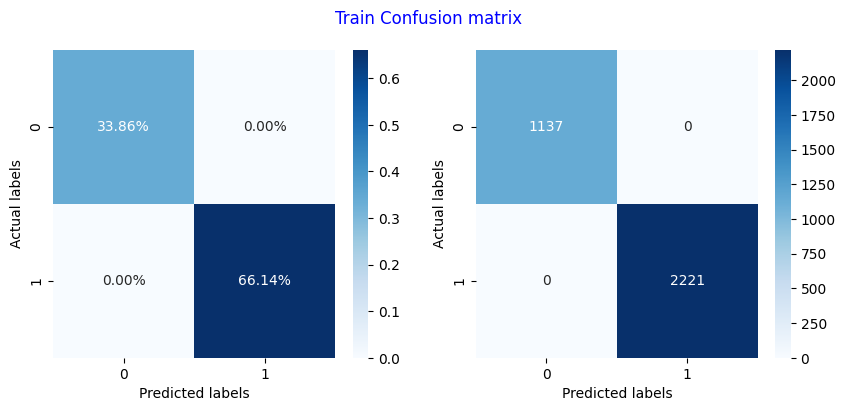

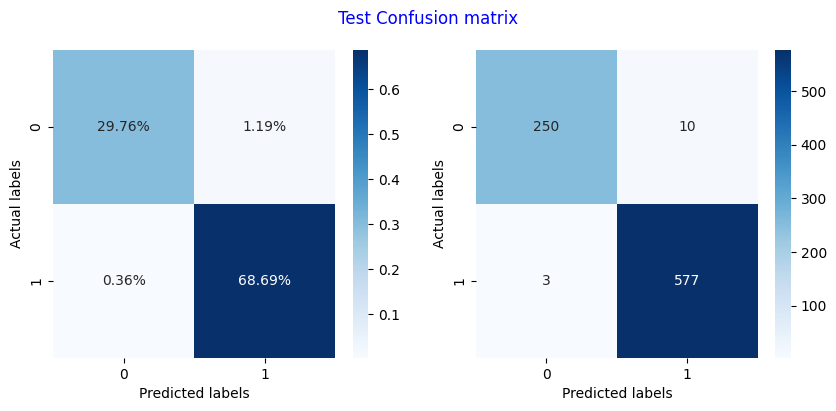

In [33]:
plot_confusion_matrix(conf_mat_train, "Train")
plot_confusion_matrix(conf_mat_test,"Test")

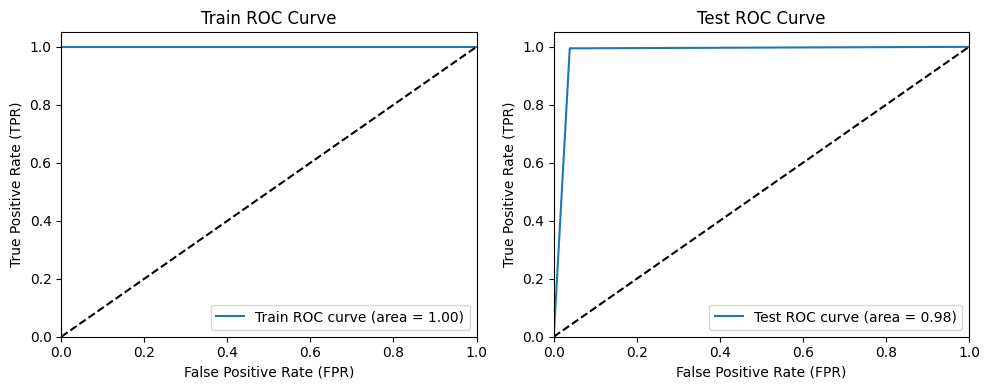

In [34]:
plot_roc_curve(KNN_classifier, X_train, y_train_bin, X_test, y_test_bin)

# **Decision Tree**

In [35]:
DT_classifier = DecisionTreeClassifier()

DT_classifier.fit(X_train, y_train_bin)

y_pred_train = DT_classifier.predict(X_train)
y_pred_test = DT_classifier.predict(X_test)

In [36]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Train')

Metrics for Train data
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [37]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Test')

Metrics for Test data
Accuracy: 0.9773809523809524
Precision: 0.9811320754716981
Recall: 0.9862068965517241
F1 Score: 0.9836629406706793


In [38]:
conf_mat_train = confusion_matrix(y_train_bin, y_pred_train)
conf_mat_test = confusion_matrix(y_test_bin, y_pred_test)

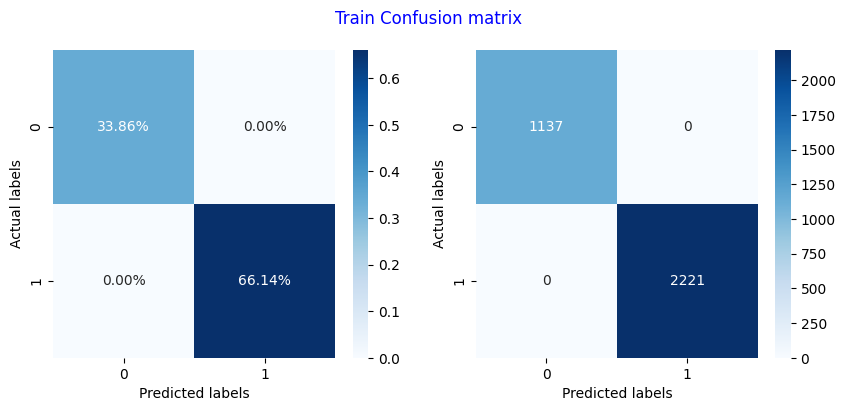

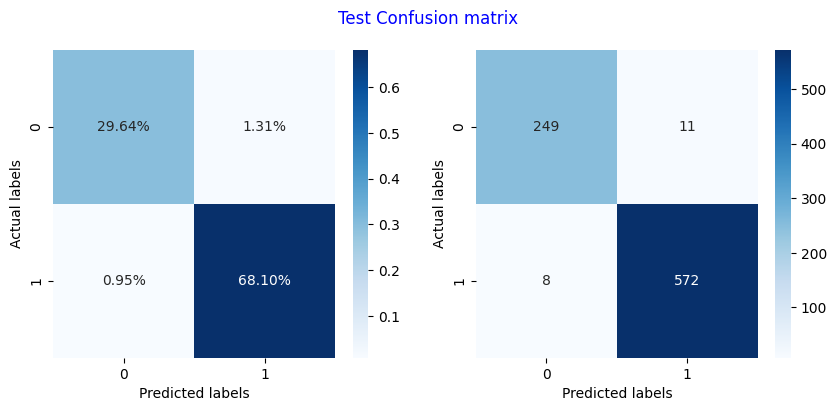

In [39]:
plot_confusion_matrix(conf_mat_train, "Train")
plot_confusion_matrix(conf_mat_test,"Test")

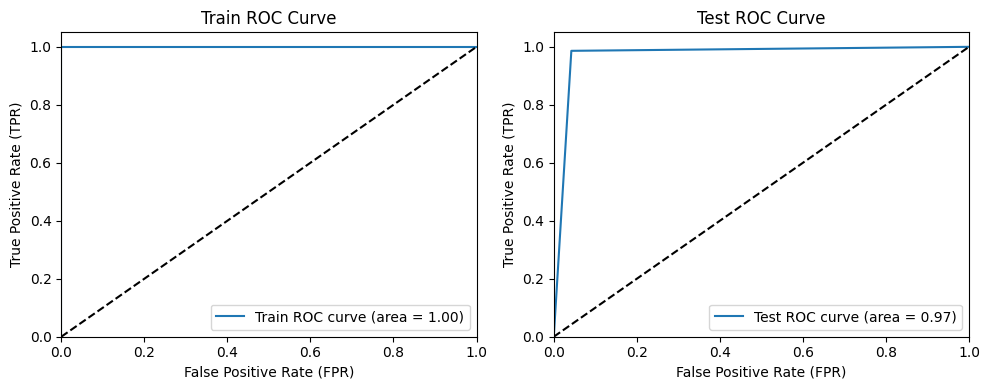

In [40]:
plot_roc_curve(DT_classifier, X_train, y_train_bin, X_test, y_test_bin)

# **Logistic Regression**

In [41]:
# logReg_model = LogisticRegression()
# rsc_params = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.01, 0.1, 1, 10, 100, 1000],
#     'max_iter': [100, 1000, 2500, 5000],
#     'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
#     }
# randomSearch_logReg = RandomizedSearchCV(logReg_model, rsc_params, cv=5, n_jobs=-1, verbose=1, scoring='f1')
# randomSearch_logReg.fit(X_train, y_train_bin)

In [42]:
# print(f'Best params: {randomSearch_logReg.best_params_}\nBest score: {randomSearch_logReg.best_score_}')

In [43]:
LR_classifier = LogisticRegression()

LR_classifier.fit(X_train, y_train_bin.ravel())

y_pred_train = LR_classifier.predict(X_train)
y_pred_test = LR_classifier.predict(X_test)

c:\Users\HI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Train')

Metrics for Train data
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [45]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Test')

Metrics for Test data
Accuracy: 0.9952380952380953
Precision: 0.996551724137931
Recall: 0.996551724137931
F1 Score: 0.996551724137931


In [46]:
conf_mat_train = confusion_matrix(y_train_bin, y_pred_train)
conf_mat_test = confusion_matrix(y_test_bin, y_pred_test)

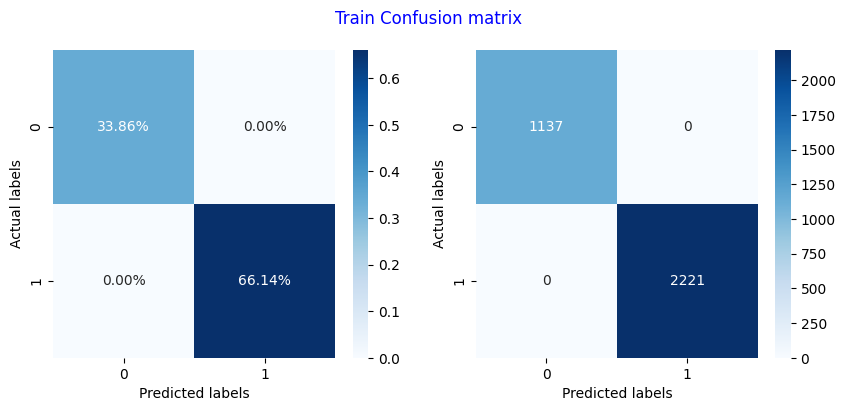

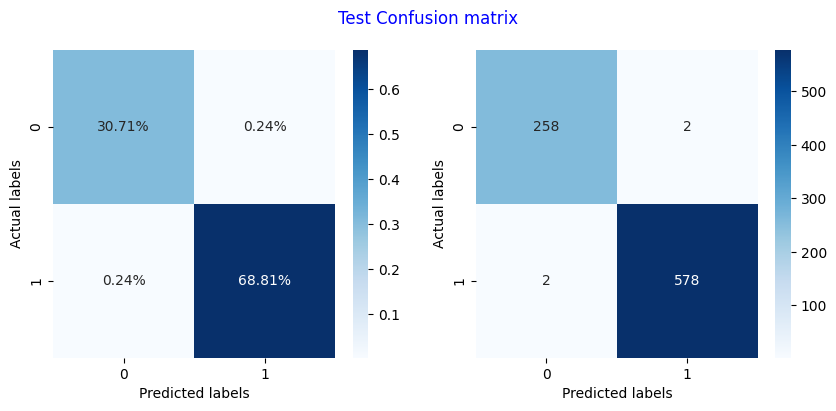

In [47]:
plot_confusion_matrix(conf_mat_train, "Train")
plot_confusion_matrix(conf_mat_test,"Test")

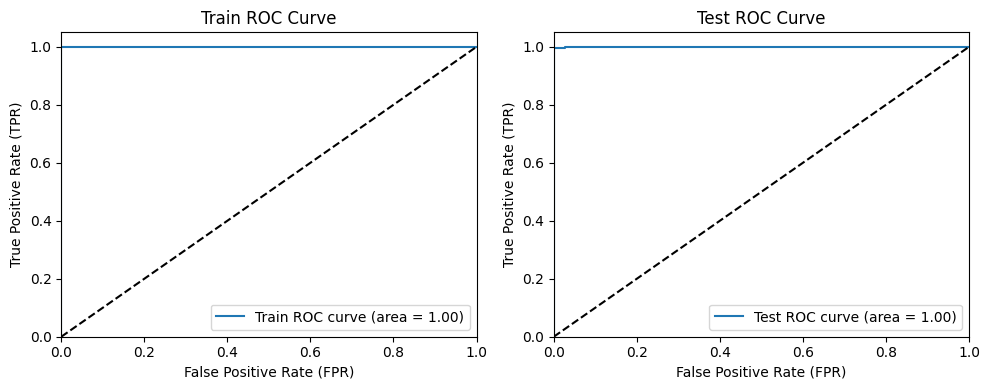

In [48]:
plot_roc_curve(LR_classifier, X_train, y_train_bin, X_test, y_test_bin)

# **Naive Bayes**

For the classification with naive bayes I ran the experiments on 3 types of naive bayes models: Multinomial, Bernoulli and Gaussian with variating the var smoothing parameter.

In [49]:
naiveBayes_model_multinomial = MultinomialNB()
naiveBayes_model_bernouli = BernoulliNB()
naiveBayes_model_gaussian = GaussianNB()

In [50]:
alphas = np.logspace(0, -9, num=100)

naiveBayes_model_multinomial_scores = []

for alpha in alphas:
    naiveBayes_model_multinomial = MultinomialNB(alpha=alpha)

    multinomial_score = cross_val_score(naiveBayes_model_multinomial, X_train, y_train_bin.ravel(), cv=5, scoring='f1')

    naiveBayes_model_multinomial_scores.append(multinomial_score.mean())

In [51]:
best_param_naive_bayes = alphas[np.argmax(np.array(naiveBayes_model_multinomial_scores))]
best_score_naive_bayes = multinomial_score.max()
best_param_naive_bayes, best_score_naive_bayes

(1e-06, 0.9716874292185731)

In [52]:
NAIV_classifer = MultinomialNB(alpha=best_param_naive_bayes)
NAIV_classifer.fit(X_train, y_train_bin.ravel())

y_pred_train = NAIV_classifer.predict(X_train)
y_pred_test = NAIV_classifer.predict(X_test)

In [53]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Train')

Metrics for Train data
Accuracy: 0.9693269803454437
Precision: 0.9862258953168044
Recall: 0.9671319225574065
F1 Score: 0.976585587633553


In [54]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Test')

Metrics for Test data
Accuracy: 0.9571428571428572
Precision: 0.9822695035460993
Recall: 0.9551724137931035
F1 Score: 0.9685314685314685


In [55]:
conf_mat_train = confusion_matrix(y_train_bin, y_pred_train)
conf_mat_test = confusion_matrix(y_test_bin, y_pred_test)

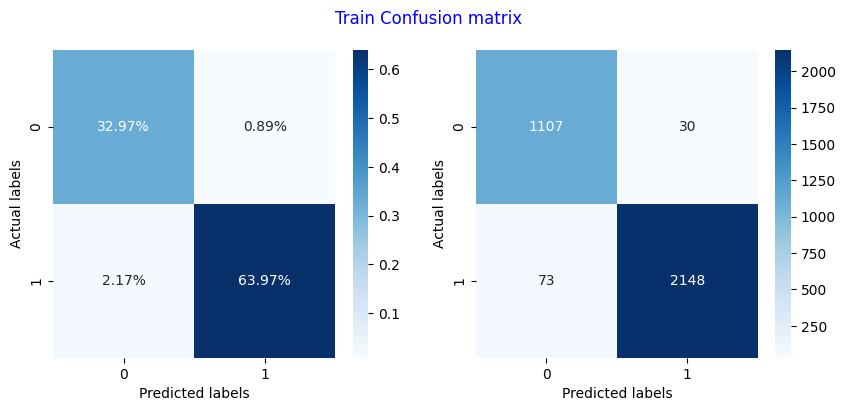

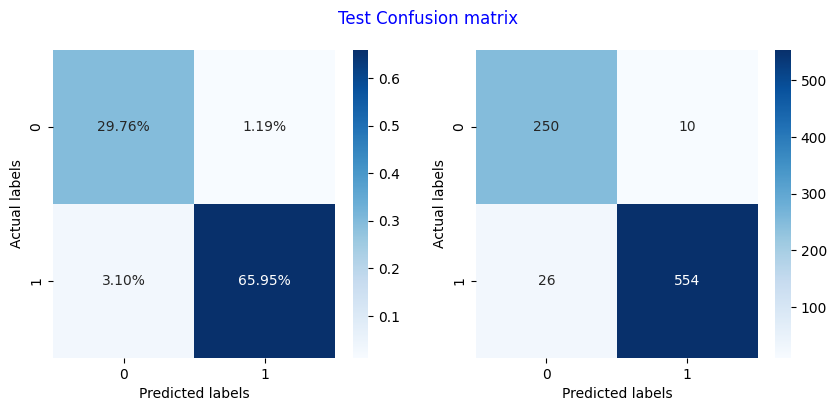

In [56]:
plot_confusion_matrix(conf_mat_train, "Train")
plot_confusion_matrix(conf_mat_test,"Test")

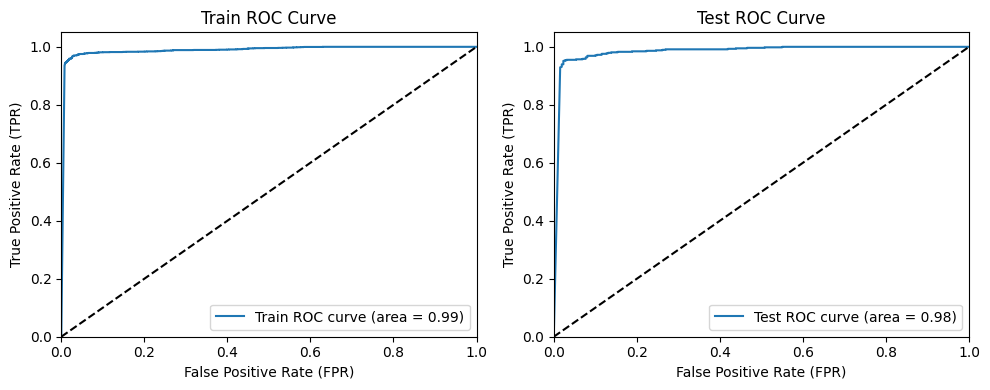

In [57]:
plot_roc_curve(NAIV_classifer, X_train, y_train_bin, X_test, y_test_bin)

# **SVM**

In [58]:
from sklearn import svm

svm_classifier = svm.SVC(kernel='linear',probability=True)

svm_classifier.fit(X_train, y_train_bin.ravel())

y_pred_train = svm_classifier.predict(X_train)
y_pred_test = svm_classifier.predict(X_test)

In [59]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Train')

Metrics for Train data
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [60]:
compute_metrics(y_train_bin, y_pred_train, y_test_bin, y_pred_test, 'Test')

Metrics for Test data
Accuracy: 0.9952380952380953
Precision: 0.9948453608247423
Recall: 0.9982758620689656
F1 Score: 0.9965576592082617


In [61]:
conf_mat_train = confusion_matrix(y_train_bin, y_pred_train)
conf_mat_test = confusion_matrix(y_test_bin, y_pred_test)

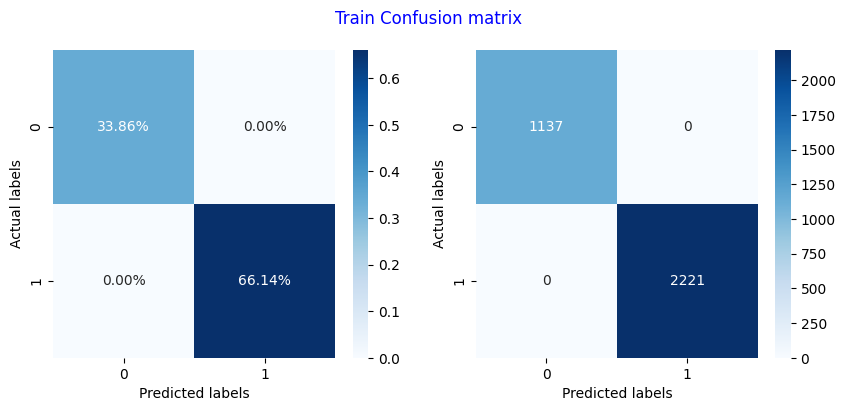

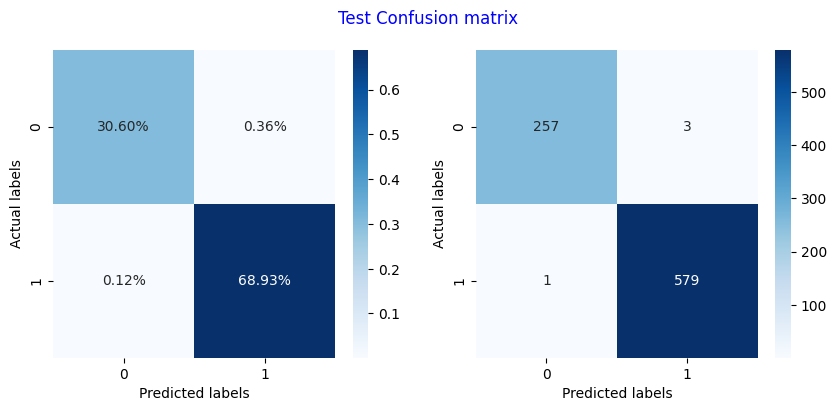

In [62]:
plot_confusion_matrix(conf_mat_train, "Train")
plot_confusion_matrix(conf_mat_test,"Test")

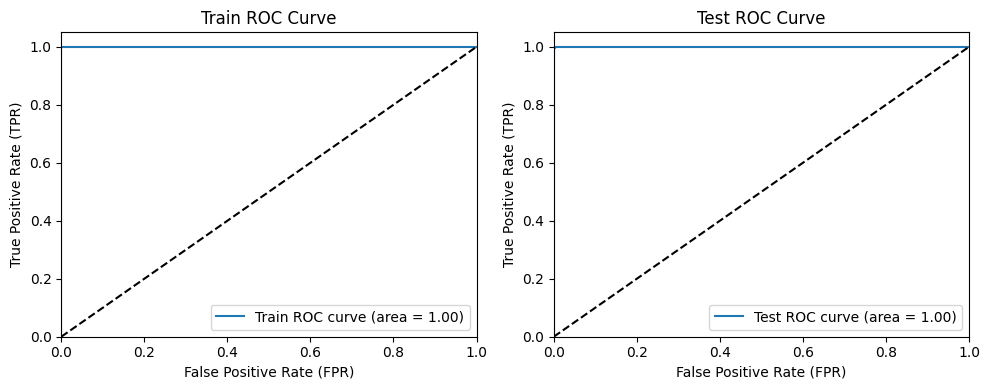

In [63]:
plot_roc_curve(svm_classifier, X_train, y_train_bin, X_test, y_test_bin)